In [2]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Test
using BenchmarkTools;

In [24]:
#Hyperparameters
n = 150 #50
N = 4 * n #200
σₐ = 0.005
k_range = 5
k_real = 8
#k_list = [2,12,22,32,42,52] Novemeber 2 - first success
k_list = [4,6,8,10,12] #November 3
k_list_lite = [i for i in 1:k_range];

#Helper Functions
mₖ(k) = k*4 + 1; #Total parameter size of the net

function unpack(Θ,k)
    m = length(Θ)
    h = 2*k
    Wₕ = reshape(Θ[1:h], k, 2);   
    bₕ = reshape(Θ[h+1:h+k], k)
    #bₕ = reshape(zeros(k), k)
    
    Wₒ = reshape(Θ[h+k+1:m-1], 1, k);
    bₒ = Θ[m]
    #bₒ = 0.0
      
    return Wₕ, bₕ, Wₒ, bₒ
end

function data_labeller(y::Array{Float64})
    labels = [y[i] > 0.5 ? 2 : 1 for i=1:length(y)]
    return labels
end

function plot_data(data,classes,alpha=1.0)
    markers = ["o","*"]
    colors = ["blue","green"]
    for i=1:2
        mask = [classes[j] == i for j in 1:length(classes)]
        scatter(data[:,1][mask],data[:,2][mask],c=colors[i],alpha=alpha,marker=markers[i],zorder=3)
    end
end;

In [33]:
#Generative Classifier Network
function G(x, Θ::AbstractVector, k::Int)
    if(typeof(x) == Float64)
        x = [x]
    end
    W₁, b₁, W₂, b₂ = unpack(Θ,k)
    nn = Chain(Dense(W₁, b₁, relu),
               Dense(W₂, [b₂]))
    return nn(x)
end;

#Create a random net
@gen function generator(x::Array{Float64}, k=8)
    σₖ = 100.0::Float64
    
    #k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    #k_real = k_list[k]
    k_real = k
    
    # Create the weight and bias vector.
    m = mₖ(k_real)
    μ = ones(m).*0
    Σ = Diagonal([σₖ for i=1:m])
    Θ ~ mvnormal(μ,Σ) #Coefficients of the polynomial
    
    #Return Network Scores for X
    scores = Flux.σ.(G(x,Θ,k_real))
    
    #Logistic Regression Likelihood
    #y = @trace(mvnormal(vec(scores), Diagonal([0.01 for i=1:length(x[1,:])])), (:y))

    return scores
end;

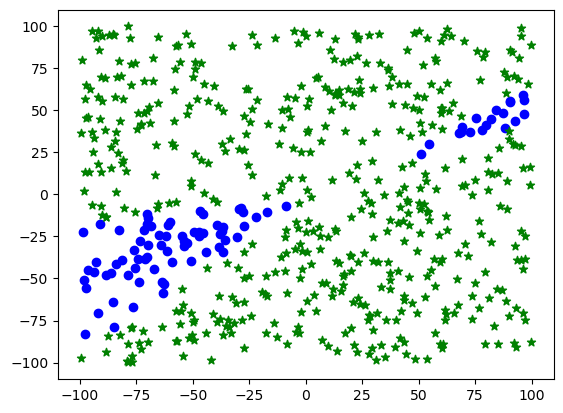

In [47]:
#Generate Network Parameters and Corresponding Curve
obs = choicemap()::ChoiceMap
x_raw = rand(Uniform(-100,100),(N,2))
x = transpose(x_raw)
(trace,) = generate(generator, (x, k_real), obs)
Θ = trace[:Θ]
scores = Flux.σ.(G(x,Θ,k_real))
y_real = data_labeller(scores)
plot_data(x_raw, y_real)

In [81]:
#Classifier Network
@gen function classifier(x::Array{Float64})
    σₖ = 100.0::Float64
    
    k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    k_real = k_list[k]
    
    # Create the weight and bias vector.
    m = mₖ(k_real)
    μ = ones(m).*0
    Σ = Diagonal([σₖ for i=1:m])
    Θ ~ mvnormal(μ,Σ) #Coefficients of the polynomial
    
    #Return Network Scores for X
    scores = Flux.σ.(G(x,Θ,k_real))
    
    #Logistic Regression Likelihood
    y = @trace(mvnormal(vec(scores), Diagonal([0.01 for i=1:length(x[1,:])])), (:y))

    return scores
    
end;

In [82]:
#Register Observed Data - Bernoulli
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_real .- 1
obs = obs_master;

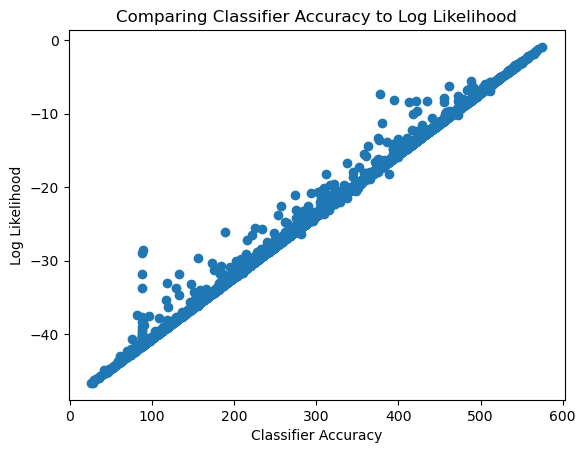

In [83]:
#Plot of Log Likelihood Scores
scores = []
accs = []
ks = []
(best_trace,) = generate(classifier, (x,), obs)
best_score = get_score(best_trace)/length(y_real)
best_Θ = best_trace[:Θ]
best_k = best_trace[:k]

best_pred_y = G(x,best_Θ,k_list[best_k])
best_pred_labels = data_labeller(best_pred_y)
best_acc = sum([best_trace[:y][i] == best_pred_labels[i] for i=1:length(y_real)])/length(y_real)

function likelihood(best_acc)
    (trace,) = generate(classifier, (x,), obs)
    
    Θ = trace[:Θ]
    k = trace[:k]
    pred_y = G(x,Θ,k_list[k])
    pred_labels = data_labeller(pred_y)

    acc = sum([y_real[i] == pred_labels[i] for i=1:length(y_real)])
    score = get_score(trace)/length(y_real)
    if acc > best_acc
        best_score = score
        best_trace = trace
        best_acc = acc
        best_pred_labels = pred_labels
    end
    push!(scores,score)
    push!(accs,acc)
    push!(ks, k)
end

for i=1:10000
    likelihood(best_acc)
end

scatter(accs,scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood");

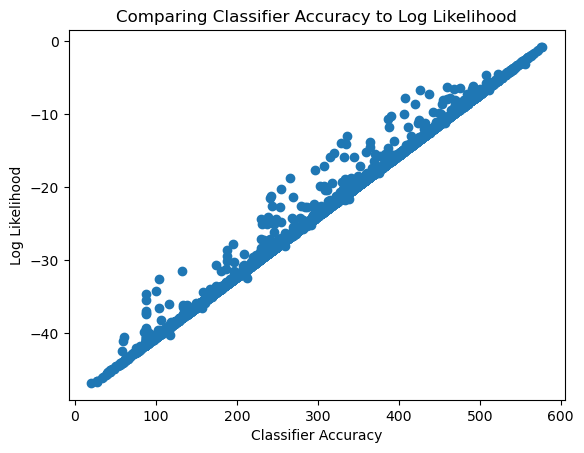

In [84]:
#Plot of Log Likelihood Scores
chains = 8
iters = 1250

function likelihood()
    scores = []
    accs = []
    ks = []
    (best_trace,) = generate(classifier, (x,), obs)
    best_score = get_score(best_trace)/length(y_real)
    best_Θ = best_trace[:Θ]
    best_k = best_trace[:k]

    best_pred_y = G(x,best_Θ,k_list[best_k])
    best_pred_labels = data_labeller(best_pred_y)
    best_acc = sum([best_trace[:y][i] == best_pred_labels[i] for i=1:length(y_real)])/length(y_real)
    
    for i=1:iters
        (trace,) = generate(classifier, (x,), obs)

        Θ = trace[:Θ]
        k = trace[:k]
        pred_y = G(x,Θ,k_list[k])
        pred_labels = data_labeller(pred_y)

        acc = sum([y_real[i] == pred_labels[i] for i=1:length(y_real)])
        score = get_score(trace)/length(y_real)
        if acc > best_acc
            best_score = score
            best_trace = trace
            best_acc = acc
            best_pred_labels = pred_labels
        end
        push!(scores,score)
        push!(accs,acc)
        push!(ks, k)
    end
    
    return scores, accs, best_trace
end

scores = zeros(chains,iters)
accs = zeros(chains,iters)
best_traces = [best_trace for i=1:chains]

function parallel_like()
    Threads.@threads for i in 1:chains
        @inbounds (scores[i,:], accs[i,:], best_traces[i]) = likelihood()
    end
end

parallel_like()

accs = vec(accs)
scores = vec(scores)

scatter(accs,scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood");

In [89]:
traces = [[] for i=1:chains]
acc = [[] for i=1:chains]

function within_dimension(trace, iters, i)
    for j=1:iters
        (trace, accepted) = hmc(trace, select(:Θ), L=10, eps=0.01, check=false, observations=obs[i])
        #println("Within dimension: $(trace[:k])")
        push!(traces[i], trace)
        push!(acc[i], accepted)
    end
    return trace
end

function across_dimension(trace, iters, i)
    selection = select(:Θ,:k)
    
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    (new_trace, weight) = regenerate(trace, args, argdiffs, selection)
    test = true
    
    #first successful run: 100, 5, 0.05
    #second attempt: 10, 5, 0.05
    for j=1:10
        (new_trace, accepted) = hmc(new_trace, select(:Θ), L=10, eps=0.01, check=false, observations=obs[i])
        accepted && (test = false)
    end
    
    #test && println("Nothing accepted")
    
    score1 = exp(get_score(trace)/length(x))
    score2 = exp(get_score(new_trace)/length(x))
    score = score2/score1
    
    if rand(Uniform(0,1)) < score
        trace = new_trace
        new_k = trace[:k]
        #println("New k accepted! Current k: $(new_k)")
        push!(acc[i],true)
    else
        #println("Sticking with the old k!")
        push!(acc[i],false)
    end
    
    obs[i] = obs_master
    obs[i][:k] = trace[:k]
        
    push!(traces[i], trace)
    return trace, trace[:k]
end

function rjmcmc(starting_trace, iters, i)
    trace = starting_trace
    k = obs[i][:k]
    println("Beginning RJMCMC. Starting k: $k")
    #@showprogress 1 "Sampling..." for i = 1:iters
    for j=1:iters
        #println("Iter $j")
        if j%1000 == 0
            println("Core $i Epoch $j Acceptance Prob: $(sum(acc[i])/length(acc[i]))")
        end
        
        if rand(Uniform(0,1)) > 0.95
            (trace, k) = across_dimension(trace, 1, i)
        else
            (trace) = within_dimension(trace, 1, i)
        end
    end
end;

In [90]:
#Parallel Run of the Sampler
chains = 8
iters = 10000 #20000 is successful

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_real .- 1
obs = [obs_master for i in 1:chains]
starting_traces = [generate(classifier, (x,), obs[i])[1] for i=1:chains]
#starting_traces = [best_trace for i=1:chains]

for i=1:chains
    obs[i][:k] = starting_traces[i][:k]
    #println(obs[i][:k])
end

function parallel_rjmcmc()
    Threads.@threads for i=1:chains
        #@inbounds println("Chain $i")
        #@inbounds println(obs[i][:k])
        @inbounds rjmcmc(starting_traces[i], iters, i)
    end
end

function normal_rjmcmc()
    rjmcmc(starting_traces[1],iters,1)
end

parallel_rjmcmc()
#normal_rjmcmc()
println("Finished")

Beginning RJMCMC. Starting k: 5
Beginning RJMCMC. Starting k: 5
Beginning RJMCMC. Starting k: 5
Beginning RJMCMC. Starting k: 5
Beginning RJMCMC. Starting k: 5
Beginning RJMCMC. Starting k: 5
Beginning RJMCMC. Starting k: 5
Beginning RJMCMC. Starting k: 5
Core 2 Epoch 1000 Acceptance Prob: 0.2062062062062062
Core 5 Epoch 1000 Acceptance Prob: 0.7247247247247247
Core 6 Epoch 1000 Acceptance Prob: 0.5585585585585585
Core 1 Epoch 1000 Acceptance Prob: 0.5355355355355356
Core 4 Epoch 1000 Acceptance Prob: 0.7387387387387387
Core 3 Epoch 1000 Acceptance Prob: 0.1891891891891892
Core 8 Epoch 1000 Acceptance Prob: 0.6666666666666666
Core 7 Epoch 1000 Acceptance Prob: 0.7637637637637638
Core 5 Epoch 2000 Acceptance Prob: 0.6783391695847923
Core 2 Epoch 2000 Acceptance Prob: 0.1135567783891946
Core 1 Epoch 2000 Acceptance Prob: 0.2681340670335168
Core 6 Epoch 2000 Acceptance Prob: 0.40370185092546274
Core 4 Epoch 2000 Acceptance Prob: 0.8294147073536768
Core 3 Epoch 2000 Acceptance Prob: 0.4217

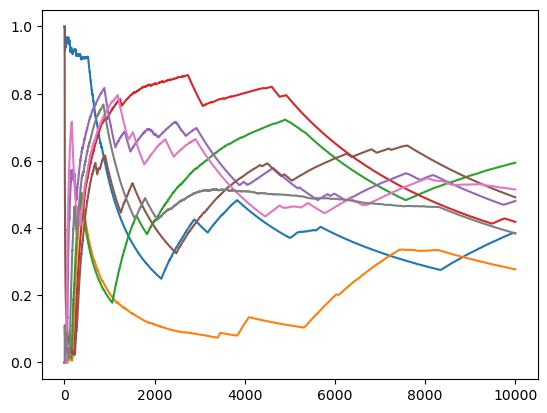

In [91]:
for i=1:chains
    acceptance = [sum(acc[i][1:j])/j for j=1:length(acc[i])]
    plt.plot(acceptance)
end

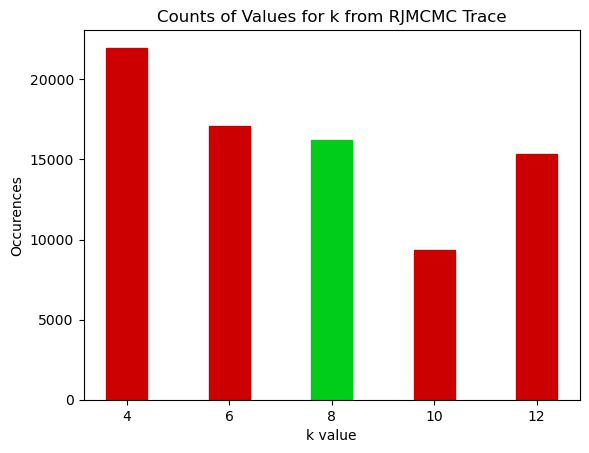

In [92]:
#Bar Plot of k estimates
ks = [[traces[i][j][:k] for j=1:length(traces[i])] for i=1:chains]
ks = collect(Iterators.flatten(ks))

counts = [sum([k_list[ks[i]] == j for i in 1:length(ks)]) for j in k_list]
barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[3].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from RJMCMC Trace")
plt.xlabel("k value")
plt.ylabel("Occurences");